# Toxic Comment Classification

In [4]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer
pd.plotting.register_matplotlib_converters()
%matplotlib inline

%load_ext autoreload
%autoreload 2
from help_tool import help_tool


pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cleaning the dataset
Dataset is made from Wikipedia comments.
* Data has no duplicates and no missing values, there's 159571 observations and 8 features
* Dataset is made of 6 labels, where comment can have multiple labels or none
* Some comments have timestamps, Wikipedia specific strings, in English and other languages - these will be cleaned

In [5]:
train = help_tool.csv_download(
    r'Archive\train.csv')

help_tool.first_look(train)

Dataset has 159571 observations and 8 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
id,object,0,0.0
comment_text,object,0,0.0
toxic,int64,0,0.0
severe_toxic,int64,0,0.0
obscene,int64,0,0.0
threat,int64,0,0.0
insult,int64,0,0.0
identity_hate,int64,0,0.0


In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [7]:
train['comment_text_original'] = train['comment_text']

## Wikipedia specific strings
* (talk) - Extracting the part that starts with '(talk' and ends with ')'
* Wikipedia shortcuts and images are distinct

In [8]:
train['extracted_text'] = train['comment_text'].str.extract(r"(\(talk.*?\))")
train[train['extracted_text'].notnull()]['extracted_text'].value_counts().head(10)

extracted_text
(talk)                       3099
(talk • contribs)             501
(talk · contribs)             154
(talk | contribs)             101
(talk to me)                   62
(talk · contribs)              58
(talk|contribs)                54
(talk · contribs · email)      48
(talk - contribs)              38
(talk • contrib)               34
Name: count, dtype: int64

In [9]:
train['comment_text'] = train['comment_text'].str.replace(
    r"\(talk.*?\)", "", regex=True)

In [10]:
train['comment_text'] = train['comment_text'].replace(
    {'Wikipedia:': '', 'WP:': '', 'Category:': '', 'disambiguation': '', 'otheruses': ''
     })

train = train[~ train['comment_text'].str.contains("Navbox")]

train['comment_text'] = train['comment_text'].apply(
    help_tool.replace_filenames)

## Timestamps
UTC is another highly used string.

In [11]:
train['comment_text'].str.extract(r"(\(UTC.*?\))").drop_duplicates()

,0
0,NaN
1,(UTC)
4598,(UTC+5:30)
19501,(UTC+1)
23640,(UTC−5)
24048,(UTC/GMT)
43415,(UTC+01)
61267,(UTC+0)
67088,(UTC−4)
86619,(UTC )


In [12]:
train['comment_text'] = train['comment_text'].str.replace(
    r"\(UTC.*?\)", "", regex=True)

In [13]:
combined_pattern = (
    r'\b(?:\d{1,2}, \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "31, 19 July 2006"
    r'\d{1,2} \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "31 19 July 2006"
    r'\d{1,2} [A-Za-z]{3,10}, \d{4}|'  # "31 July, 2006"
    r'\d{1,2} [A-Za-z]{3,10} \d{4}|'  # "31 July 2006"
    r'\d{1,2}, [A-Za-z]{3,10} \d{4}, \d{1,2}:\d{2}|'  # "31, July 2006, 18:47"
    r'\d{1,2} [A-Za-z]{3,10} \d{4}, \d{1,2}:\d{2}|'  # "31 July 2006, 18:47"
    r'\d{1,2} [A-Za-z]{3,10} \d{4} \d{1,2}:\d{2}|'  # "31 July 2006 18:47"
    r'\d{1,2}:\d{2}, [A-Za-z]{3,10} \d{1,2}, \d{4}|'  # "18:47, July 31, 2006"
    r'\d{1,2}:\d{2}, \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "18:47, 31 July 2006"
    r'\d{1,2}:\d{2} \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "18:47 31 July 2006"
    r'\d{1,2} [A-Za-z]{3,10} \d{1,2}:\d{2}|'  # "26 July 17:03 UTC"
    r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b'  # IP address
    r')\b'
)


# Remove the date pattern from the 'comment_text' column
train['comment_text'] = train['comment_text'].str.replace(
    combined_pattern, '', regex=True).str.strip()

train[train['id'] == '000103f0d9cfb60f']

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text_original,extracted_text
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm seemingly stuck with. Thanks.,0,0,0,0,0,0,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",(talk)


## Extract Information from URLs
In some cases, the domain or specific keywords within the URL might provide context (e.g., links to specific news sites or social media platforms)

In [14]:
train['comment_text'] = train['comment_text'].apply(
    help_tool.replace_url_with_domain)


train[train['id'] == 'fbf8672ea3b4ddf7']

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text_original,extracted_text
159315,fbf8672ea3b4ddf7,nysun - public interest crap..,1,0,0,0,0,0,http://www.nysun.com/article/23698 - public interest crap..,NaN


## NOTs 
Updating the contractions so they don't get interpretted as the different word.

In [15]:
def expand_contractions(text):
    contractions_dict = {
        "can't": "can not",
        "won't": "will not",
        "isn't": "is not",
        "aren't": "are not",
        "wasn't": "was not",
        "weren't": "were not",
        "hasn't": "has not",
        "haven't": "have not",
        "hadn't": "had not",
        "doesn't": "does not",
        "don't": "do not",
        "didn't": "did not",
        "won't": "will not",
        "wouldn't": "would not",
        "shouldn't": "should not",
        "mightn't": "might not",
        "mustn't": "must not",
        "couldn't": "could not"
    }

    # Regular expression for finding contractions
    contractions_re = re.compile(
        r'\b(' + '|'.join(re.escape(key) for key in contractions_dict.keys()) + r')\b')

    # Replace contractions using the dictionary
    expanded_text = contractions_re.sub(
        lambda match: contractions_dict[match.group(0)], text)

    return expanded_text


train['comment_text'] = train['comment_text'].apply(
    help_tool.expand_contractions)

## Text normalization

In [16]:
train['comment_text'] = train['comment_text'].apply(help_tool.clean_text)
train[train['id'] == 'fbf8672ea3b4ddf7']

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text_original,extracted_text
159315,fbf8672ea3b4ddf7,nysun public interest crap,1,0,0,0,0,0,http://www.nysun.com/article/23698 - public interest crap..,NaN


## Remove Stop Words
Stop words (e.g., "and", "the", "is") are common words that may not carry much information.

In [17]:
train['comment_text'] = train['comment_text'].apply(help_tool.remove_stopwords)

In [18]:
train = train[train['comment_text'] != '']

## Duplicated values
Duplicated values are removed for no classes, while duplicates for classes are left in. This is done, because Large Language Models benefit from overfitting.

In [19]:
train['toxic_flag'] = 0

train.loc[
    (train['toxic'] == 1) | (train['severe_toxic'] == 1) | (train['obscene'] == 1) | 
    (train['threat'] == 1) | (train['insult'] == 1) | (train['identity_hate'] == 1), 
    'toxic_flag'
] = 1

In [20]:
df_non_toxic = train[~train['comment_text'].duplicated() & (train['toxic_flag'] == 0)]
df_toxic = train[(train['toxic_flag'] == 1)]

df = pd.concat([df_non_toxic, df_toxic])
df.shape

(157769, 11)

# Dataset Imbalance

In [21]:
train['toxic_flag'] = 0

train.loc[
    (train['toxic'] == 1) | (train['severe_toxic'] == 1) | (train['obscene'] == 1) | 
    (train['threat'] == 1) | (train['insult'] == 1) | (train['identity_hate'] == 1), 
    'toxic_flag'
] = 1


class_distribution = train[['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'toxic_flag']].sum().to_frame().reset_index().rename(columns={'index': 'Class', 0: 'Count'})

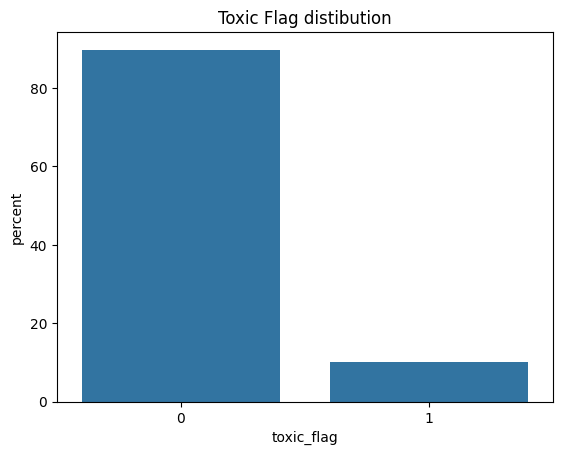

In [22]:
sns.countplot(data=train, x='toxic_flag', stat='percent')
plt.title('Toxic Flag distibution')
plt.show()

Dataset is very imbalanced, 10% of cases are toxic_flag'ed, from those 10% it is seen that 3 classes have low number compared to others

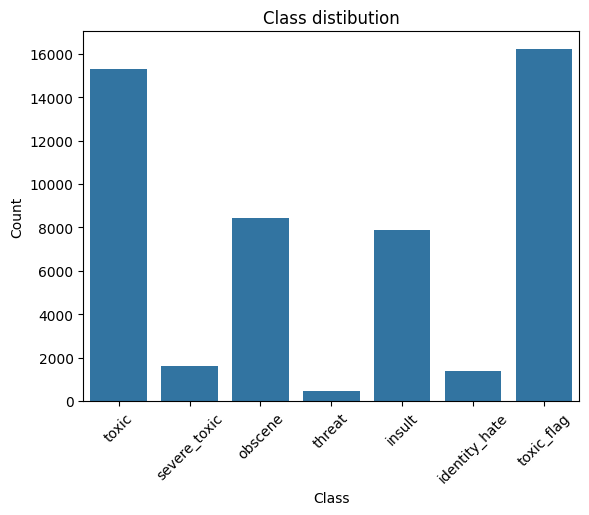

In [23]:
sns.barplot(data=class_distribution, x='Class', y='Count')
plt.title('Class distibution')
plt.xticks(rotation=45)
plt.show()

# Data augmentation
Before continueing with data augmentation (backtranslation) on minority classes:
* severe_toxic
* threat
* identity_hate

non English words will be removed

## English Words
Removing all non engligh words

In [23]:
train['language'] = train['comment_text'].apply(help_tool.detect_language)

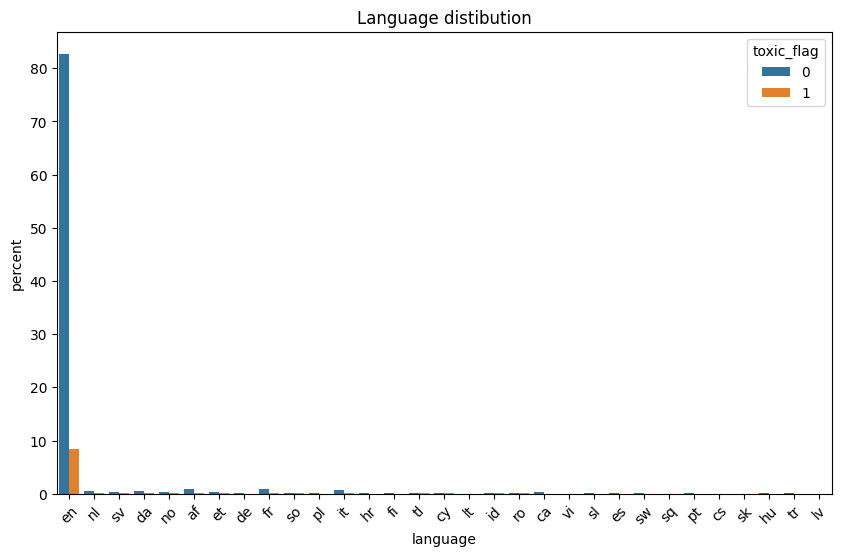

In [24]:
plt.figure(figsize=(10, 6))

sns.countplot(train, x='language', stat='percent', hue='toxic_flag')
plt.title('Language distibution')
plt.xticks(rotation=45)
plt.show()

Non English language handling. 9% of all cases are in other Languages

In [25]:
non_en_df = train[train['language'] != 'en']

In [26]:
non_en_df.shape[0] / train.shape[0] * 100

8.772656784635766

In [27]:
non_en_df[['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'toxic_flag']].sum()

toxic            2619
severe_toxic      336
obscene          1464
threat            100
insult           1344
identity_hate     318
toxic_flag       2691
dtype: int64

In [28]:
non_en_df[['toxic_flag']].sum() / non_en_df.shape[0]

toxic_flag    0.192586
dtype: float64

Non toxic comments will be removed, while toxic comments will be translated. Model langdetect identifies English jargon as other languages.

Translation by Google Translator thought the English slang and grammer mistakes are another language.

In [29]:
toxic_non_en = train[(train['language'] != 'en') & (train['toxic_flag'] != 0)]
toxic_non_en.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text_original,extracted_text,toxic_flag,language
51,001dc38a83d420cf,get fucked get fuckeeed got drink cant put get fuck get fucked im fucked right,1,0,1,0,0,0,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK THAT YOU CANT PUT DOWN???/ GET FUCK UP GET FUCKED UP. I'M FUCKED UP RIGHT NOW!,NaN,1,da
105,00472b8e2d38d1ea,pair jewhating weiner nazi schmucks,1,0,1,0,1,1,A pair of jew-hating weiner nazi schmucks.,NaN,1,de
211,0086998b34865f93,fuck block faggot pussy,1,0,1,0,1,0,"Fuck you, block me, you faggot pussy!",NaN,1,sv
238,0097dd5c29bf7a15,u r tw fuck u gay boyu r smellyfuck ur mum poopie,1,0,1,0,1,1,u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie,NaN,1,cy
423,01113aece2e95a73,careful call moron,1,0,0,0,0,0,Be careful who you call a moron.,NaN,1,ro


Translate toxic comments

In [50]:
toxic_non_en['translated_text'] = toxic_non_en['comment_text'].apply(help_tool.translate_to_english)

In [54]:
toxic_non_en = toxic_non_en[toxic_non_en['translated_text'] != toxic_non_en['comment_text']]

Šitų nepamiršti sujungit

In [56]:
toxic_non_en[['translated_text', 'comment_text', 'language']].tail()

,translated_text,comment_text,language
150282,Arororo saee fuck you can let us Euquinia you,aurora jolie n fuk yu delete wikipedia yub,id
151673,willing cold,wil kil,sw
156656,You are a mother you are not in my intention to discredit GMA Babinang Wikipedia So if you have to stop you ok hell tell sure there is rank wikipedia gives right thought Wikipedia Place people freely share Know References Resources Back View Different Way Always Gotta Taking Fing Fingblame sh you animal,ptang ina ka hayop ka wala sa aking intensyon na siraan ang gma babuyin ang wikipedia kaya kung meron man dapat tumigil ikaw yun ok hell tell sure may rank wikipedia gives right thought wikipedia place people freely share know references resources back view different way always gotta taking fing blame sh ka hayop,tl
158393,Blackky,blackkite faggot,da
159268,Hi Bading Putang Mom You Gay You Fuck You Are You Chumupa You Are Guys You Are Nothing to Do By Life Diba Your Wife's NRDG Chiunuchapaan You Mother Your Mother You really love Oten Fuck Fuck BullshitMan fuck fuck fuck your mother pork gay,hi bading putang ina mong bakla ka fuck kang bading ka chumupa ka nalang gago ka puta puta ka walang magawa sa buhay diba asawa mo si nrdg chiunuchupaan mo siya tang ina mo mahilig ka talaga sa oten fuck fuck bullshit na bading manyak mahilig manuod ng mga bold na man man fuck fuck putang ina mo baboy na bakla,tl


## Backtranslation of Toxic comments
One class is disproportionally smaller than the other - threat. Toxic comments  are translated to German and back to English 

In [106]:
train[(train['language'] == 'en') &
    (
        (train['severe_toxic'] == 1) | 
        (train['threat'] == 1)
      | (train['identity_hate'] == 1)
     )
      ][['toxic', 'severe_toxic', 'obscene', 'threat',
         'insult', 'identity_hate', 'toxic_flag']].sum()

toxic            2210
severe_toxic     1259
obscene          1915
threat            378
insult           1900
identity_hate    1087
toxic_flag       2333
dtype: int64

In [110]:
backtranslation_df = train[(train['threat'] == 1) 
                           & (train['language'] == 'en')]
backtranslation_df.shape

(378, 12)

In [111]:
backtranslation_df_de = help_tool.language_language_translation(backtranslation_df, 'en', 'de')

c:\Users\User\Desktop\Gintares_Projektai\Toxic-Comment-Classification\help_tool\help_tool.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_text_de'] = df['comment_text'].apply(lambda x: translate_text(x, language_2)).str.lower()
c:\Users\User\Desktop\Gintares_Projektai\Toxic-Comment-Classification\help_tool\help_tool.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_text_en'] = df['comment_text_de'].apply(lambda x: translate_text(x, language_1)).str.lower()


In [118]:
backtranslation_df_de = backtranslation_df_de[backtranslation_df_de['translated_text'].notna() & (backtranslation_df_de['translated_text']!='into')]

In [119]:
backtranslation_df_de[['translated_text', 'comment_text']]

,translated_text,comment_text
802,fuck smith please notify the will dance grave,fuck smith please notified die want dance grave
3029,motafucka son slut shup otherwise kill,mothafucka son bitch shup otherwise kill
4888,"i don't have the trouble, i am calling for the sign that i threaten anyone who threatens anyone who lifts control over the control policeman.",aint bothering im required sign postsedit specifically threaten anyone blowing control snide comment said im going kill fire thats different saying im going church pray gets cancer dies fire sarchastic tone pity see matter bump weeks cause
6316,lock know bulgarian bullshit season scour exactly connect you edit someone else ddax articles once next year.,lock know bulgarian bullshit season fooled exactly connect see editing someone else send ddax article one time spend next years prison arrange meeting certain people suspicions terrorism yes terror suspect nowadays kiss young life goodbye file complaints im banned naked ass whole time world cell block think went wrong
15927,swear insult to understand little coward,insult swear go understand little coward
...,...,...
152416,phil knight dies,phil knight die
153605,hey man retired mexican hahnstich pieces damn shit,hey man retarded mexican cocksucking piece fucking shit please go fucking kill wikipedia admins lower niggers fuck
154609,"listen sick, you attack bloody",listen ill attack bloody want
155840,bush nuke iran arab golf stupid persians want to see how britney spears will soon support the united states israel terrorist iranian.ask,bush nuke iran arabian gulf stupid persians wanna see britney spears ruling iran hope soon inshallah support united states israel terrorist iranians support hizbolshaitan many terrorist groups also wanna see persians beg us food stop climing arabian gulf persian


In [122]:
backtranslation_df_de['language'] = backtranslation_df_de['comment_text'].apply(help_tool.detect_language)
backtranslation_df_de['language'].value_counts()

language
en    203
Name: count, dtype: int64

Constructing a single dataframe

In [130]:
df_1 = train[train['language'] == 'en'][['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'language', 'toxic_flag']]

df_2 = backtranslation_df_de[['id', 'translated_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'language', 'toxic_flag']].rename(columns={'translated_text': 'comment_text'})

df_3 = toxic_non_en[['id', 'translated_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'language', 'toxic_flag']].rename(columns={'translated_text': 'comment_text'})

In [132]:
clean_language_df = pd.concat([df_1, df_2, df_2])
clean_language_df.shape

(145712, 10)

Threat is increased 2 times.

In [133]:
clean_language_df[clean_language_df['toxic_flag'] == 1][['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'toxic_flag']].sum()

toxic            13049
severe_toxic      1347
obscene           7271
threat             784
insult            6817
identity_hate     1199
toxic_flag       13940
dtype: int64

<Figure size 1000x600 with 0 Axes>

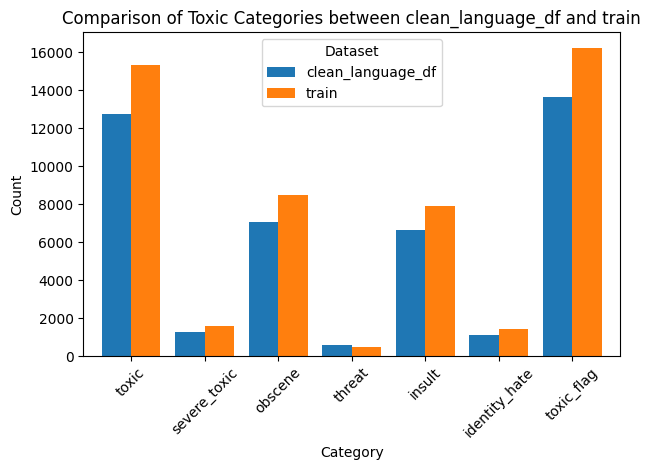

In [129]:
# Step 1: Sum up the categories for both datasets (where toxic_flag is 1)
clean_language_sum = clean_language_df[clean_language_df['toxic_flag'] == 1][['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'toxic_flag']].sum()

train_sum = train[train['toxic_flag'] == 1][['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'toxic_flag']].sum()

# Step 2: Create a DataFrame to hold both sums for easy comparison
comparison_df = pd.DataFrame({
    'clean_language_df': clean_language_sum,
    'train': train_sum
})

# Step 3: Plot the data using seaborn's barplot function
plt.figure(figsize=(10, 6))

# Create a barplot for both datasets side by side
comparison_df.plot(kind='bar', width=0.8)
plt.title("Comparison of Toxic Categories between clean_language_df and train")
plt.ylabel("Count")
plt.xlabel("Category")
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()

# Step 4: Show the plot
plt.show()

In [134]:
clean_language_df.to_csv('Archive\\clean_language_df.csv')

In [24]:
clean_language_df = pd.read_csv("Archive\\clean_data.csv").drop(columns=['Unnamed: 0'])
clean_language_df.shape

(142695, 10)

# Token Count
Checing the average token count in comments, this will be used in model training. We'll take word count of 128 as it's long enought to cover most of cases, but small enought to run.

In [31]:
MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False, clean_up_tokenization_spaces=True)

In [32]:
token_counts = []

for _, row in clean_language_df.iterrows():
  token_count = len(tokenizer.encode(
    row["comment_text"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)

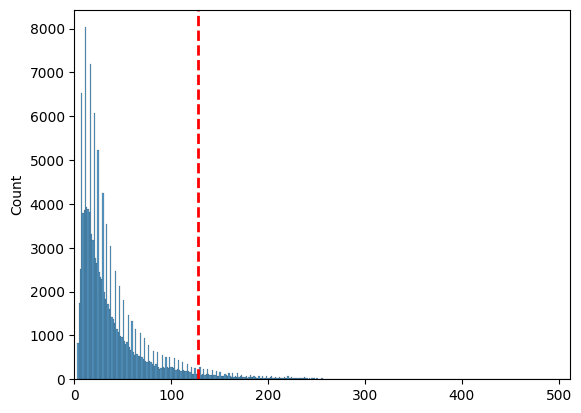

In [34]:
sns.histplot(token_counts)
plt.xlim([0, 512])
plt.axvline(x=128, color='r', linestyle='--', linewidth=2)
plt.show()

In [146]:
clean_language_df[['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'toxic_flag', 'comment_length']].to_csv(r'Archive\clean_data.csv')

In [98]:
clean_language_df = pd.read_csv(r'Archive\\clean_data.csv').drop(columns='Unnamed: 0')

# Test  data cleaning

In [40]:
LABEL_COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']

In [38]:
test_df = pd.read_csv('Archive/test.csv')
test_labels_df = pd.read_csv('Archive/test_labels.csv')
test_df = test_df.merge(test_labels_df, on='id', how='left')
test_label_cols = list(test_df.columns[2:])
print('Null values: ', test_df.isnull().values.any())
print('Same columns between train and test: ', LABEL_COLUMNS ==
      test_label_cols)  

test_df = test_df[~test_df[test_label_cols].eq(-1).any(axis=1)]
test_df['one_hot_labels'] = list(test_df[test_label_cols].values)
test_df.head()

Null values:  False
Same columns between train and test:  True


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,one_hot_labels
5,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Religion? Really?? You mean, the way people have invariably kept adding """"Religion"""" to the Samuel Beckett infobox? And why do you bother bringing up the long-dead completely non-existent """"Influences"""" issue? You're just flailing, making up crap on the fly. \n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories! \n\n """,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a type. The """"Type"""" of institution is needed in this case because there are three levels of SUNY schools: \n -University Centers and Doctoral Granting Institutions \n -State Colleges \n -Community Colleges. \n\n It is needed in this case to clarify that UB is a SUNY Center. It says it even in Binghamton University, University at Albany, State University of New York, and Stony Brook University. Stop trying to say it's not because I am totally right in this case.""",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the list, make sure it's relevant == \n\n Before adding a new product to the list, make sure it has a wikipedia entry already, """"proving"""" it's relevance and giving the reader the possibility to read more about it. \n Otherwise it could be subject to deletion. See this article's revision history.""",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [39]:
test_df = help_tool.cleaning_comments(test_df)
test_df['language'] = test_df['comment_text'].apply(help_tool.detect_language)

c:\Users\User\Desktop\Gintares_Projektai\Toxic-Comment-Classification\help_tool\help_tool.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_text'] = df['comment_text'].apply(replace_filenames)
c:\Users\User\Desktop\Gintares_Projektai\Toxic-Comment-Classification\help_tool\help_tool.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_text'] = df['comment_text'].apply(clean_text)
c:\Users\User\Desktop\Gintares_Projektai\Toxic-Comment-Classification\help_tool\help_tool.py:264: Set

Unfortunetelly, Google Translate did not identify short sentences with slang as English. These will be left in.

In [90]:
test_df[test_df['language'] != 'en']['comment_text']

16                                                        one
40                                  redirect talkmi vida eres
59                                      fuck antisemitic cunt
60                                            puwersa ng masa
76        dare vandalize page hms beagle dont vandalize demon
                                 ...                         
153006                         us favour stop lazysloppy best
153020                                       reply sockpuppet
153040                   good work like images keep good work
153049                                       well feel stupid
153087                                        yatt got insane
Name: comment_text, Length: 7514, dtype: object

In [ ]:
test_path = r"Archive\\test_df.csv"

# Conclusion
Training data was cleaned by removing common Wikipedia words, timestamps, non Englist words. Token count max length was chosen as 100 words, as 75% of cases are below this threshold.